positions for peaks of Al(main) phase are: [38.235, 44.463, 64.696, 77.763, 81.881, 98.312]


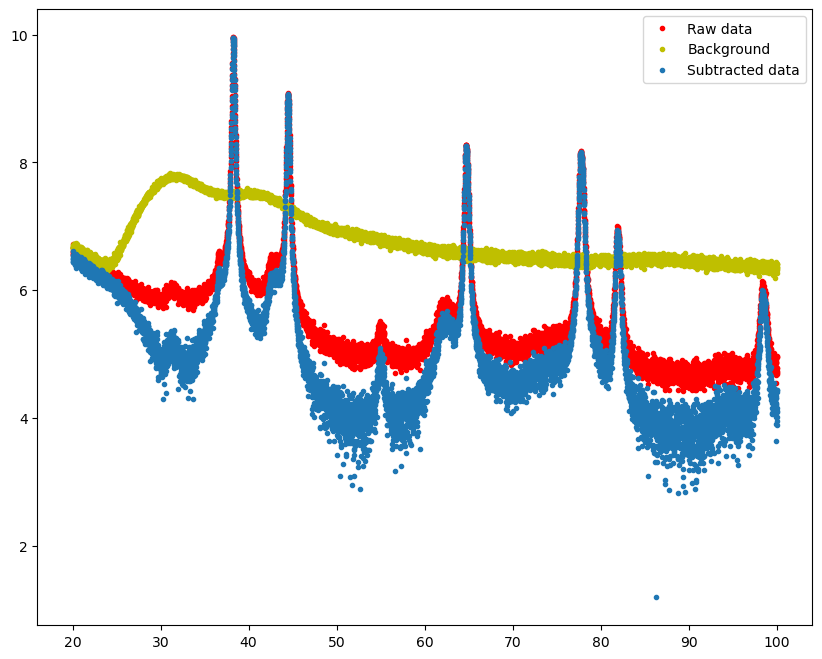

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.pyplot import figure
from scipy.signal import argrelextrema 

df = pd.read_csv('WD_As-sintered_top_scanning.csv')
bg = pd.read_csv('WD_background.csv')

# find out approx. peak position for Al phase
i = 30
pp = []
while i < 100:
    if i <50 or i >= 60: 
        filtered_df = df[(df['Angle'] >= i) & (df['Angle'] <= i+10)]
        pp.append(df.loc[filtered_df['Intensity'].idxmax(), 'Angle'])
        i += 10
    else:
        i += 10
print("positions for peaks of Al(main) phase are:", pp)

# background subtraction under log scale 
x1 = df['Angle'].values 
log_df = np.log(df['Intensity'].values)
log_bg = np.log(bg['Intensity'].values)
I = df['Intensity'].values - bg['Intensity'].values * 0.1
I_log = np.log(I)
background =[800, 400, 200, 200, 50, 0]

plt.figure(figsize=(10, 8))
plt.plot(x1, log_df,'r.', label='Raw data')
plt.plot(x1, log_bg,'y.',label='Background')
plt.plot(x1, I_log,'.',label='Subtracted data');
plt.legend()

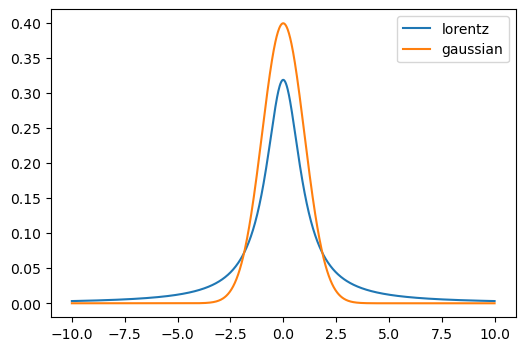

In [5]:
# functions of Gaussian distribution and Lorentzian(Cauchy) distribution
def gaussian(x, mu, sigma, a, b):
    power = -0.5*((x-mu)/sigma)**2
    fit = np.exp(power) / (sigma*np.sqrt(2*np.pi))
    return a*fit+b

def lorentzian(x, x0, gamma, a, b):
    fit = 1 / (np.pi * gamma * (1 + ((x - x0) / gamma)**2))
    return a*fit+b

# functions for broadening calculations
def broadening_g(fwhm):
    return 0.5*fwhm*np.sqrt(np.pi/np.log(2))

def broadening_l(fwhm):
    return np.pi*fwhm/2

# show the peak shape of two distributions
x = np.linspace(-10, 10, 1000)
y_l = lorentzian(x, x0=0, gamma=1, a=1, b=0)
y_g = gaussian(x, mu=0, sigma=1, a=1, b=0)
plt.figure(figsize=(6, 4))
plt.plot(x, y_l, label='lorentz')
plt.plot(x, y_g, label='gaussian')
plt.legend()



For the peak at around 38.235°
Fitting of Gaussian distribution:
χ²/dof = 70.914
Flux = 5760.115 ± 57.436
R² = 0.995
Fitting of Lorentzian distribution:
χ²/dof = 38.144
Flux = 9767.745 ± 106.051
R² = 0.997
Lorentzian distribution is best fitting for this peak,
the peak locates at μ = 38.258 ± 0.001 °

For the peak at around 44.463°
Fitting of Gaussian distribution:
χ²/dof = 18.771
Flux = 2644.324 ± 24.757
R² = 0.996
Fitting of Lorentzian distribution:
χ²/dof = 11.749
Flux = 4735.058 ± 52.850
R² = 0.997
Lorentzian distribution is best fitting for this peak,
the peak locates at μ = 44.478 ± 0.001 °

For the peak at around 64.696°
Fitting of Gaussian distribution:
χ²/dof = 5.608
Flux = 1482.976 ± 20.493
R² = 0.993
Fitting of Lorentzian distribution:
χ²/dof = 7.062
Flux = 3044.927 ± 74.425
R² = 0.992
Gaussian distribution is best fitting for this peak,
the peak locates at μ = 64.743 ± 0.001 °

For the peak at around 77.763°
Fitting of Gaussian distribution:
χ²/dof = 4.439
Flux = 1630.948 

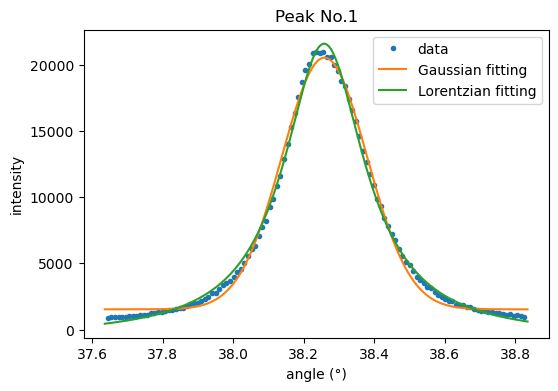

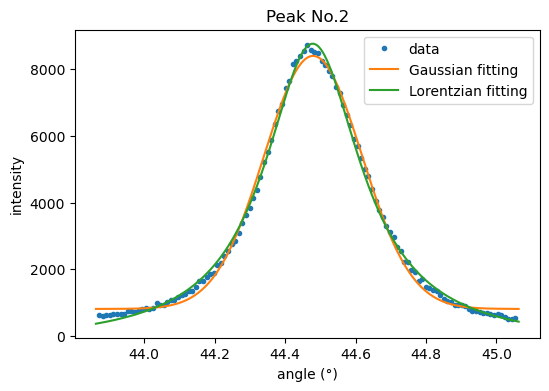

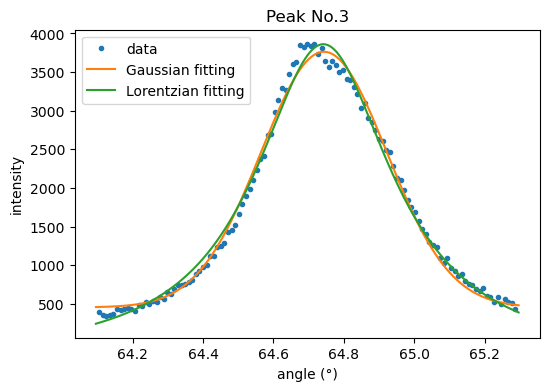

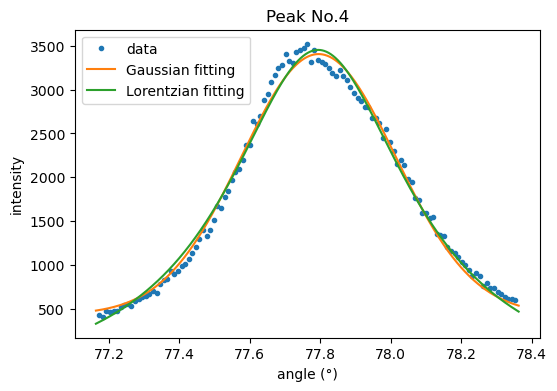

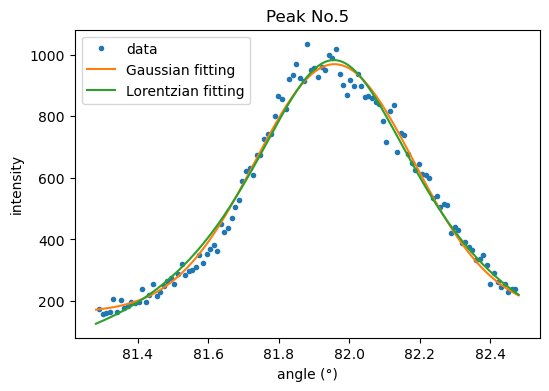

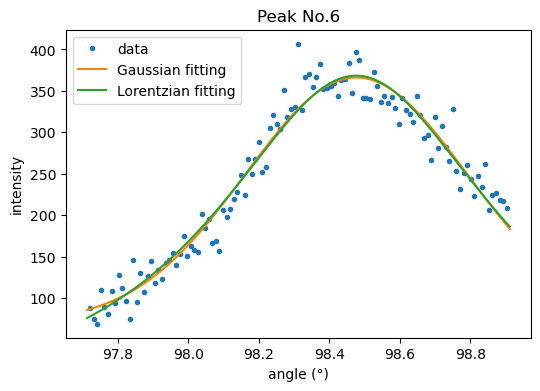

In [6]:
j = 0
pp_f = []
fwhm = []
I_f = []
b_f = []
# data selecting this small range is becasue I try to avoid some other minor peaks, who partially overlapped with the main peak
while j < 6:
      a1 = (x1 >= (pp[j]-0.6)) & (x1 <= (pp[j]+0.6))
      i1 = I[a1]
      plt.figure(figsize=(6, 4))
      plt.plot(x1[a1], i1, '.', label='data')

# Gaussian fitting
      best_vals, covar = curve_fit(gaussian, x1[a1], i1, p0=[pp[j], 0.8, I[np.isclose(x1, pp[j])][0],background[j]])

      mug = best_vals[0]
      sigma1 = best_vals[1]
      flux = best_vals[2]
      bg1 = best_vals[3]
      err_mu1 = np.sqrt(np.diag(covar))[0]
      err_flux = np.sqrt(np.diag(covar))[2]

      xfit = np.linspace(pp[j]-0.6, pp[j]+0.6, num=10000)
      yfit = gaussian(xfit,mug,sigma1,flux,bg1)
      plt.plot(xfit,yfit,label="Gaussian fitting")

      plt.xlabel(r'angle (°)')
      plt.ylabel('intensity')
      plt.legend()
      
      #observed_values = I[a1]
      #expected_values = gaussian(x1[a1],mug,sigma1,flux,bg1)
      # Print out the observed and expected values
      #print('First 10 observed values (I[a1]):', observed_values[:50])
      #print('First 10 expected values (Gaussian fit):', expected_values[:50])
      # Calculate chi-square
      #chisq = np.sum(((observed_values - expected_values)/np.sqrt(expected_values))**2)


# Calculate Chi^2
      chisq = np.sum(((i1-gaussian(x1[a1],mug,sigma1,flux,bg1))/np.sqrt(gaussian(x1[a1],mug,sigma1,flux,bg1)))**2)
      dof = len(i1) - len(best_vals)                  
      cod = chisq/dof                                  # chi square / degree of freedom      
# Calculate R^2
      TSS = np.sum((i1 - np.mean(i1))**2)
      RSS = np.sum((i1 - gaussian(x1[a1], mug, sigma1, flux, bg1))**2)
      rsq = 1 - (RSS/TSS)
      print('\nFor the peak at around {}°'.format(pp[j]))
      print('Fitting of Gaussian distribution:')
      print('\u03C7\u00b2/dof =', "{:.3f}".format(cod))
      print('Flux =', "{:.3f}".format(abs(flux)), u"\u00B1","{:.3f}".format(err_flux))
      print(u"R\u00b2 =", "{:.3f}".format(rsq))


# Lorentz fitting
      best_vals_l, covar_l = curve_fit(lorentzian, x1[a1], i1, p0=[pp[j], 0.8, I[np.isclose(x1, pp[j])][0], background[j]])

      mul = best_vals_l[0]
      gamma1 = best_vals_l[1]
      flux_l = best_vals_l[2]
      bg1_l = best_vals_l[3]
      err_x0_1 = np.sqrt(np.diag(covar_l))[0]
      err_flux_l = np.sqrt(np.diag(covar_l))[2]

      yfit_l = lorentzian(xfit, mul, gamma1, flux_l, bg1_l)
      plt.plot(xfit, yfit_l, label="Lorentzian fitting")

      plt.title('Peak No.{}'.format(j+1))
      plt.xlabel(r'angle (°)')
      plt.ylabel('intensity')
      plt.legend()

# Calculate Chi^2 for Lorentz fit
      chisq_l = np.sum(((i1 - lorentzian(x1[a1],mul,gamma1,flux_l,bg1_l)) / np.sqrt(lorentzian(x1[a1],mul,gamma1,flux_l,bg1_l)))**2)
      dof_l = len(i1) - len(best_vals_l)                  
      cod_l = chisq_l/dof_l
# Calculate R^2 for Lorentzian fit
      RSS_l = np.sum((i1 - lorentzian(x1[a1], mul, gamma1, flux_l, bg1_l))**2)
      rsq_l = 1 - (RSS_l/TSS)
      print('Fitting of Lorentzian distribution:')
      print('\u03C7\u00b2/dof =', "{:.3f}".format(cod_l))
      print('Flux =', "{:.3f}".format(abs(flux_l)), u"\u00B1", "{:.3f}".format(err_flux_l))
      print(u"R\u00b2 =", "{:.3f}".format(rsq_l))

      if rsq > rsq_l or cod < cod_l:
            print("Gaussian distribution is best fitting for this peak,")
            print(u"the peak locates at \u03BC", '=', "{:.3f}".format(mug), u"\u00B1","{:.3f}".format(err_mu1), '°')
            pp_f.append(mug)
            fwhm.append(2.35482 * sigma1)
            I_f.append(gaussian(mug, mug, sigma1, flux, background[j]))
            b_f.append(broadening_g(2.35482 * sigma1))

      elif rsq < rsq_l or cod > cod_l:
            print("Lorentzian distribution is best fitting for this peak,")
            print(u"the peak locates at \u03BC", '=', "{:.3f}".format(mul), u"\u00B1", "{:.3f}".format(err_x0_1), '°')
            pp_f.append(mul)
            fwhm.append(2*gamma1)
            I_f.append(lorentzian(mul, mul, gamma1, flux_l, background[j]))
            b_f.append(broadening_l(2*gamma1))
      j += 1


fitted peaks locate at [38.2577618493174, 44.47849060545337, 64.74329832837516, 77.79501976931213, 81.9581797853648, 98.4761763411248] 
their FWHM are  [0.28019450427342424, 0.33411163422722445, 0.4209863448438088, 0.5153948270620812, 0.5319022813179082, 0.7408692898430114] 
their intensity are  [22992.940044109506, 9422.228042428958, 3509.283662743814, 3172.8155861403548, 855.3501969210158, 296.03620576194857] 
 their total broadening are  [0.4401284981008117, 0.5248213277835642, 0.44812607971713553, 0.5486207953930459, 0.5661924360231433, 0.7886309247473196]
Slope: -0.9718491134295945
Intercept: 1.0042108300828485


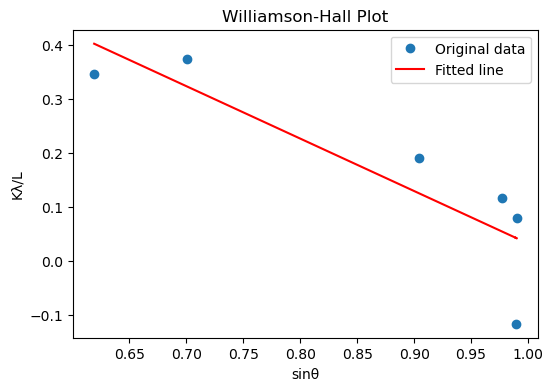

The lattice paramter calculated from fitted curve is 4.309425146002878
 From above W-H plot, the crystalline size is 1.3807259974338346, the micro-strain is -0.24296227835739861.
The parameters from Topas here are, LP = 4.1Å, crystalline size = 51.2, strain = 0.14. There are two reason mainly result in the big difference.
First, there still are some minor peak partially overlap with the main peaks I fitted, which may cause peak shifting. 
Second, some instrumental broadening factors have not been counted into this analysis, which can result in the large error on the calculation of crystallite size and microstrain.


In [8]:
print("fitted peaks locate at", pp_f, "\ntheir FWHM are ", fwhm, "\ntheir intensity are ", I_f, "\n their total broadening are ", b_f)
d = []
a = []
Mi_ns = [3, 4, 8, 11, 12, 16]           # Miller indices normal square
x_WH = []
y_WH = []
# calculate parameters
k = 0
while k < 6:
    d.append(1.5406 / np.sin(np.radians(pp_f[k])))
    x_WH.append(np.sin(np.radians(pp_f[k])))
    y_WH.append(b_f[k]*np.cos(np.radians(pp_f[k])))
    a.append(d[k]*np.sqrt(Mi_ns[k]))
    k += 1
x_WH_np = np.array(x_WH)
y_WH_np = np.array(y_WH)

# Perform linear fitting
slope, intercept = np.polyfit(x_WH_np, y_WH_np, 1)

# Print the fitted slope and intercept
print('Slope:', slope)
print('Intercept:', intercept)

# Plot the data and the fitted line

plt.figure(figsize=(6, 4))
plt.xlabel('sin\u03B8')
plt.ylabel('K\u03BB/L')
plt.title('Williamson-Hall Plot')
plt.plot(x_WH_np, y_WH_np, 'o', label='Original data')
plt.plot(x_WH_np, slope*x_WH_np + intercept, 'r', label='Fitted line')
plt.legend()
plt.show()

strain = slope/4
grain_size = 0.9*1.5406/intercept

print('The lattice paramter calculated from fitted curve is {}\n From above W-H plot, the crystalline size is {}, the micro-strain is {}.'.format(a[0], grain_size, strain))


print('The parameters from Topas here are, LP = 4.1Å, crystalline size = 51.2, strain = 0.14. There are two reason mainly result in the big difference.')
print('First, there still are some minor peak partially overlap with the main peaks I fitted, which may cause peak shifting. ')
print('Second, some instrumental broadening factors have not been counted into this analysis, which can result in the large error on the calculation of crystallite size and microstrain.')